In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# Comment out the two lines below if you don't have latex compiler installed - this is for nicer formula rendering
plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsfonts}'

In [2]:
from mol_utils import PotentialModel
from mol_utils import MLP
from mol_utils import geodesic
from mol_utils import annealed_langevin_dynamics
from mol_utils import visualize_energy
from mol_utils import visualize_spacetime_curve
from mol_utils import visualize_transition_paths

In [3]:
# Model approximating the energy function
state_dict = torch.load('potential_model.pt')
pot_model = PotentialModel([64, 64])
pot_model.load_state_dict(state_dict)

<All keys matched successfully>

In [4]:
# Approximate denoiser
model = MLP(
    hidden_size=128,
    hidden_layers=3,
    emb_size=128,
    time_emb="sinusoidal",
    input_emb="sinusoidal"
)
model.load_state_dict(torch.load('diffusion_model.pt'))

<All keys matched successfully>

### Geodesics

In [ ]:
MAX_LOG_SNR = 4
NUM_INTERMEDIATE_POINTS = 128

In [ ]:
# Points in spacetime. The `time` component is represented with l=logSNR(t), instead of t.
theta1 = torch.tensor([MAX_LOG_SNR, -2.55, 2.7]).float()
theta2 = torch.tensor([MAX_LOG_SNR, 0.95, -0.4]).float()

In [ ]:
shortest_path = geodesic(
    theta1, theta2, model, n_opt_steps=10000,
    num_intermediate_points=NUM_INTERMEDIATE_POINTS, num_nodes=10,
    mode='unconstrained'
)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [06:04<00:00, 27.44it/s, energy=1.08]


/Users/karczer1/Projects/neurips2025_submission/code/molecular_experiments/mol_utils.py:365: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:264.)
  inp = torch.tensor([x, y]).view(2, -1).T


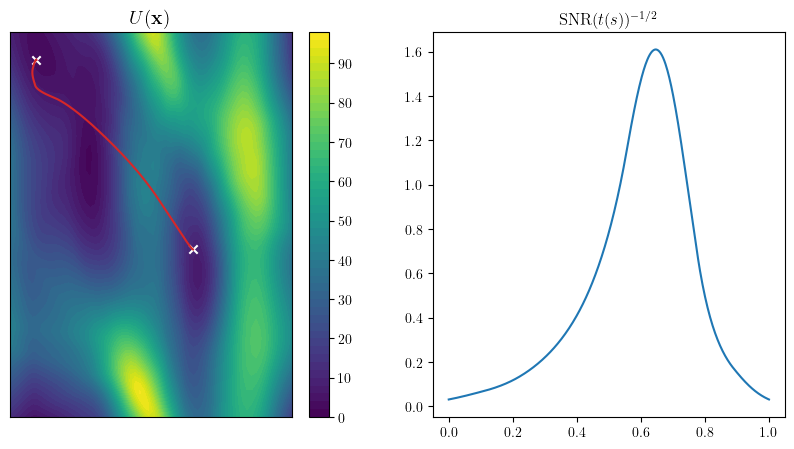

In [7]:
visualize_spacetime_curve(shortest_path, pot_model)

In [ ]:
ald_path = annealed_langevin_dynamics(
    potential_model=pot_model,
    n_paths=8,
    n_lan_steps=128,
    ds=0.0004,
    curve=shortest_path
)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [00:26<00:00, 19.08it/s]


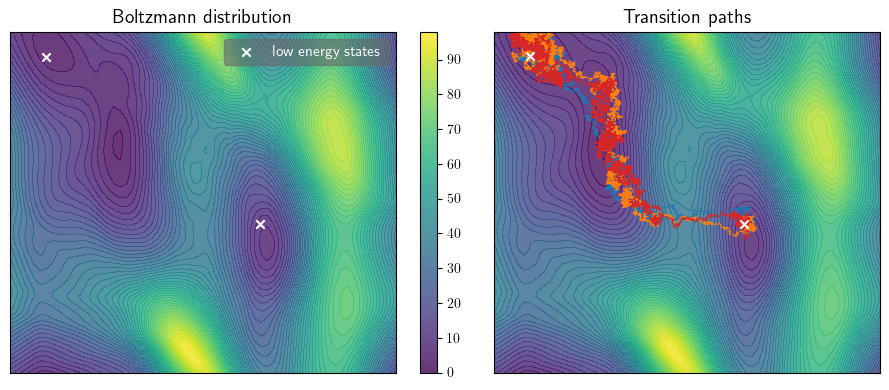

In [9]:
visualize_transition_paths(ald_path, pot_model)

In [10]:
low_variance_path = geodesic(
    theta1, theta2, model, n_opt_steps=4000,
    num_intermediate_points=1024, num_nodes=10, mode='low-variance')

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4000/4000 [03:34<00:00, 18.68it/s, energy=1.81]


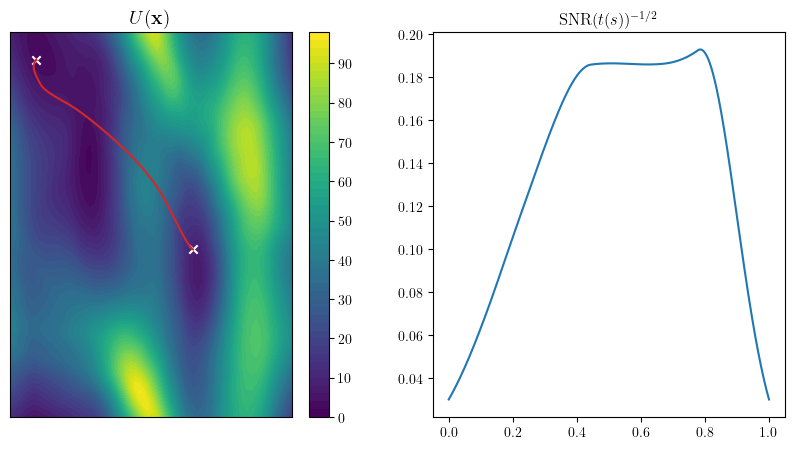

In [11]:
visualize_spacetime_curve(low_variance_path, pot_model)

In [12]:
low_variance_ald_path = annealed_langevin_dynamics(
    potential_model=pot_model,
    n_paths=8,
    n_lan_steps=128,
    ds=0.0001,
    curve=low_variance_path
)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1024/1024 [00:53<00:00, 19.22it/s]


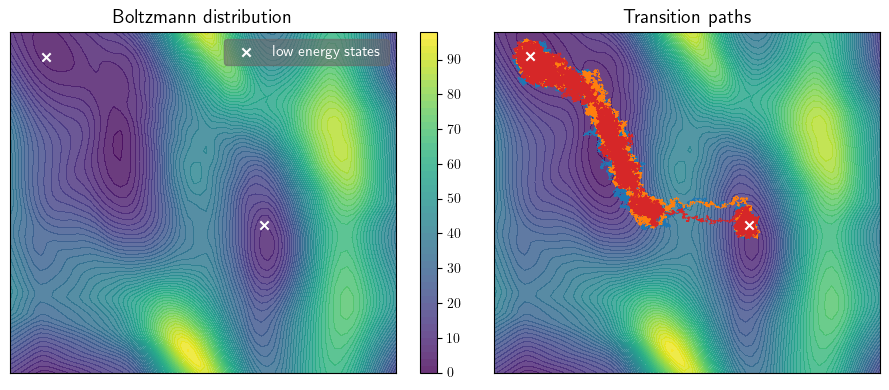

In [13]:
visualize_transition_paths(low_variance_ald_path, pot_model)

In [14]:
theta_star = torch.tensor([4, -0.8, -0.1])
region_avoiding_path = geodesic(
    theta1, theta2, model, n_opt_steps=4000,
    num_intermediate_points=1024, 
    num_nodes=10, mode='region-avoiding', theta_star=theta_star
)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4000/4000 [03:57<00:00, 16.88it/s, energy=2.85]


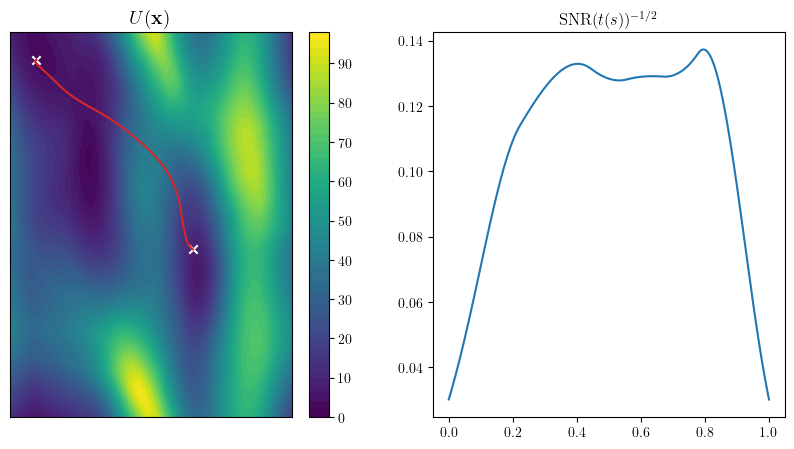

In [15]:
visualize_spacetime_curve(region_avoiding_path, pot_model)

In [16]:
region_avoiding_ald_path = annealed_langevin_dynamics(
    potential_model=pot_model,
    n_paths=8,
    n_lan_steps=128,
    ds=0.0001,
    curve=region_avoiding_path
)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1024/1024 [00:53<00:00, 19.10it/s]


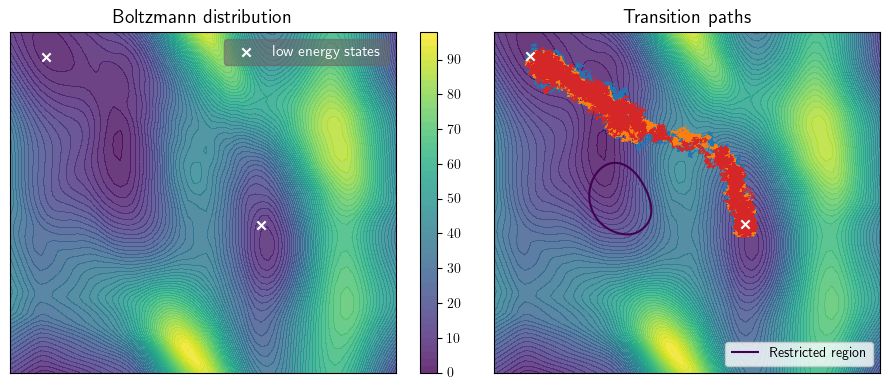

In [17]:
visualize_transition_paths(region_avoiding_ald_path, pot_model,
                           show_restricted_region=True, theta_star=theta_star)